In [66]:
# Initialize Otter
import otter
grader = otter.Notebook()

# Lab 7: Simple Linear Regression

### Objective

In this lab, we will review some of the details of how linear regression works as described in Lectures 12 and 13.

We will also show you how to do linear regression using various real world tools including:
- (Question 1) `seaborn`
- (Question 2) formulaic
- (Question 3) `scipy.optimize`
- (Question 4) `scikit-learn`

In real world data science work, you are far more likely to use something similar to the `seaborn` and `scikit-learn` approaches, but it is important to know how to use the formulaic and `scipy.optimize` approaches so that you understand what is really going on.

**This assignment should be completed and submitted before 11:59 PM on Monday, October 12th.**


### Collaboration Policy

Data science is a collaborative activity. While you may talk to others about the labs, we ask that you **write your solutions individually**. If you do discuss the assignments with others, please **include their names** in the following cell:

_List collaborators here_

In [67]:
# Run this cell
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [68]:
# Run this cell to suppress all DeprecationWarnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

We begin by importing the tips dataset that we also explored in Lab 6.

In [69]:
tips = sns.load_dataset("tips")

In [70]:
tips.head(5)

total_bill   tip     sex smoker  day    time  size
0       16.99  1.01  Female     No  Sun  Dinner     2
1       10.34  1.66    Male     No  Sun  Dinner     3
2       21.01  3.50    Male     No  Sun  Dinner     3
3       23.68  3.31    Male     No  Sun  Dinner     2
4       24.59  3.61  Female     No  Sun  Dinner     4

In Lab 6, we fit a **constant** model to this dataset, meaning our model was $\hat{y} = \theta$. In other words, given the set of tips `tips['tip']`, we tried to find a summary statistic $\theta$ that best represented our set of tips. To find the value of $\theta$, we minimized the following empirical risk:

$$R(\theta) = \frac{1}{n}\sum_{i = 1}^n L(y_i, \theta)$$

Here, $\mathcal{D} = \{y_1, y_2, ..., y_n \}$ refers to our set of `tips` values.

We looked at two different loss functions:

- $L_2$: $L_2(y_i, \hat{y_i}) = (y_i - \hat{y_i})^2$

- $L_1$: $L_1(y_i, \hat{y_i}) = \left| y_i - \hat{y_i} \right|$


<br>

By contrast, in this lab, we're interested in studying the **relationship between two variables**. Specifically, we're interested in the relationship between the `total_bill` column and `tip` column. Our goal will be to predict tip ($y$) from total_bill ($x$), i.e., we want to find values of $a$ and $b$ so that given $x$, predict $y$ as
$$\boxed{\hat{y} = a + bx}$$
We will now explore different ways to obtain the optimal values of $a, b$, called $\hat{a}, \hat{b}$, where $\hat{y} = \hat{a} + \hat{b}x$.

First, let's run `sns.lmplot`, which will both provide a scatterplot of `tip` vs `total_bill` and also display the least-squares line of best fit. This line of best fit is what we will look to determine empirically in three different ways: manually using the formula from lecture, `scipy.optimize`, and `scikit-learn`.

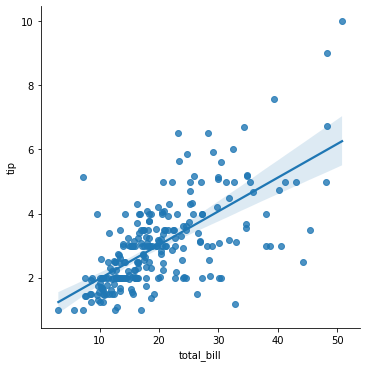

In [71]:
sns.lmplot(data = tips, x = "total_bill", y = "tip");

## Question 1 – Manual Formulation

In [Lecture 12](http://www.ds100.org/fa20/lecture/lec12), we derived the following expression for the line of best fit.

$$\hat{y_i} = \bar{y} + r \frac{SD(y)}{SD(x)} (x_i - \bar{x})$$

where $\bar{x}$, $\bar{y}$, $SD(x)$, $SD(y)$ correspond to the means and standard deviations of $x$ and $y$, respectively, and $r$ is the correlation coefficient.

### Question 1a

Assign `x_bar`, `y_bar`, `std_x`, `std_y`, and `r`, such that they align with our dataset. Note: Make sure to use `np.std`, and not `<Series name>.std()`.

- Hint: Remember, in our case, `y` is `tip`, and `x` is `total_bill`.
- Hint: You may find `np.corrcoef` handy in computing `r`. Note that the output of `np.corrcoef` is a matrix, not a number, so you'll need to collect the correlation coefficient by indexing into the returned array.

<!--
BEGIN QUESTION
name: q1a
-->

In [72]:
x_bar = np.mean(tips['total_bill'])
y_bar = np.mean(tips['tip'])
std_x = np.std(tips['total_bill'])
std_y = np.std(tips['tip'])
r = np.corrcoef(tips['total_bill'], tips['tip'])[0, 1]

In [73]:
grader.check("q1a")

All tests passed!

### Question 1b

Now, set `b_hat` and `a_hat` correctly, in terms of the variables you defined above. 

- Hint: Try and match the slope and intercept in $\hat{y_i} = \hat{a} + \hat{b}x_i$ to the slope and intercept in $\hat{y_i} = \bar{y} + r \frac{SD(y)}{SD(x)} (x_i - \bar{x})$.

- Hint: You may want to define `a_hat` in terms of `b_hat`.

<!--
BEGIN QUESTION
name: q1b
-->

In [74]:
b_hat = r * std_y / std_x
a_hat = y_bar - b_hat * x_bar

In [75]:
grader.check("q1b")

All tests passed!

### Question 1c

Now, use `a_hat` and `b_hat` to predict the tip for a total bill amount of $20. Store your result in `predicted_20`.

<!--
BEGIN QUESTION
name: q1c
-->

In [76]:
predicted_20 = a_hat + b_hat * 20
predicted_20

3.0207599612417404

In [77]:
grader.check("q1c")

All tests passed!

### Question 1d
Assign `regression` to be a `pd.Series` of predicted $y$ values (i.e., predicted `"tip"` values) for the observed total bills (`tips["total_bill"]`). You will need to use `a_hat`, `b_hat`, and `tips["total_bill"]`.

<!--
BEGIN QUESTION
name: q1d
-->

In [78]:
regression = a_hat + b_hat * tips["total_bill"]

In [79]:
grader.check("q1d")

All tests passed!

If you defined `regression` correctly, the following cell will generate a scatter plot of `tip` vs. `total_bill`, along with the line of best fit you just computed.

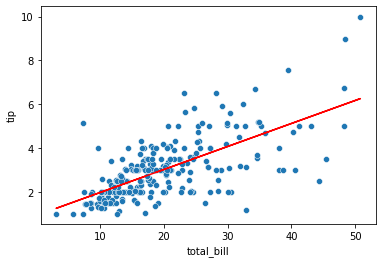

In [80]:
sns.scatterplot(x='total_bill', y='tip', data=tips)
plt.plot(tips["total_bill"], regression, color = 'r')
plt.xlabel('total_bill')
plt.ylabel('tip');

### Question 1e

Consider $r$, the correlation coefficient between `tips` and `total_bill`.

In [81]:
r

0.6757341092113641


**In the cell below**, comment on the value of $r$, and what it means in the context of the above scatter plot.

There is a moderate positive relationship between total bill and tips. 

## Question 2 – Using Scipy Minimize

`scipy.minimize` is a powerful method that can determine the optimal value of a variety of different functions. In practice, it is used to minimize functions that have no (or difficult to obtain) analytical solutions (it is a **numerical method**).

It is overkill for our simple example, but nonetheless, we will show you how to use it, as it will become useful in the near future.

### Question 2a

First, fill out the definition of `l2_tip_risk` so that it computes the empirical risk for a given choice of `a` and `b`. That is, it computes

$$R(a, b) = \frac{1}{n} \sum_{i = 1}^n(y_i - (a + b x_i))^2$$

where, again, $x$ and $y$ refer to `"total_bill"` and `"tip"`.

<!--
BEGIN QUESTION
name: q2a
-->

In [82]:
def l2_tip_risk(a, b):
    """Returns average l2 loss between regression line for intercept a 
       and slope b"""
    predicted_y = a + b * tips["total_bill"]
    return np.mean((tips["tip"] - predicted_y) ** 2)

In [83]:
grader.check("q2a")

All tests passed!

Try out different `a` and `b` values. Observe that if you pick values close to the ones from the earlier part of this lab then the risk is lower. 

In [84]:
l2_tip_risk(0.9, 0.1)

1.052336405737705

The `minimize` function we saw in Lab 6 can also minimize functions of multiple variables. There's one quirk, however, which is that the function has to accept its parameters as a single list.

For example, consider the multivariate $f(u, v) = u^2 - 2 u v - 3 v + 2 v^2$. It turns out this function's minimum is at $(1.5, 1.5)$. To minimize this function, we create `f`.

In [85]:
def f(theta):
    u = theta[0]
    v = theta[1]
    return u**2 - 2 * u * v - 3 * v + 2 * v**2

In [86]:
from scipy.optimize import minimize
minimize(f, x0 = [0.0, 0.0]) 

# As an aside: x0 is the "initial guess" for the optimal theta. minimize works iteratively.
# We will study an iterative algorithm for function minimization in the coming weeks.

      fun: -2.2499999999999982
 hess_inv: array([[0.99999999, 0.5       ],
       [0.5       , 0.5       ]])
      jac: array([-5.96046448e-08,  0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 16
      nit: 3
     njev: 4
   status: 0
  success: True
        x: array([1.49999995, 1.49999997])

### Question 2b

Define `l2_tip_risk_list` which is exactly like `l2_tip_risk` except that it takes in a single list of 2 variables rather than two separate variables. For example `l2_tip_risk_list([2, 3])` should return the same value as `l2_tip_risk(2, 3)`.

<!--
BEGIN QUESTION
name: q2b
-->

In [87]:
def l2_tip_risk_list(theta):
    """Returns average l2 loss between regression line for intercept a 
       and slope b"""
    a = theta[0]
    b = theta[1]
    predicted_y = a + b * tips["total_bill"]
    return np.mean((tips["tip"] - predicted_y) ** 2)
    

In [88]:
grader.check("q2b")

All tests passed!

### Question 2c

Now, set `minimized` to the result of calling `minimize` to optimize this risk function.

- Hint: Make sure to set `x0`.

<!--
BEGIN QUESTION
name: q2c
-->

In [89]:
minimized = minimize(l2_tip_risk_list, x0 = [0.0, 0.0])

Let's look at the output of your call to `minimize`.

In [90]:
minimized

      fun: 1.0360194420114932
 hess_inv: array([[ 2.9799997 , -0.1253415 ],
       [-0.1253415 ,  0.00633488]])
      jac: array([-4.47034836e-08, -2.98023224e-08])
  message: 'Optimization terminated successfully.'
     nfev: 20
      nit: 3
     njev: 5
   status: 0
  success: True
        x: array([0.92027035, 0.10502448])

The following cell will print out the values of `a_hat` and `b_hat` computed from both methods ("manual" refers to the technique in Question 1). If you've done everything correctly, these should be very close to one another.

In [91]:
print('a_hat_scipy: ', minimized['x'][0])
print('a_hat_manual: ', a_hat)
print('\n')
print('b_hat_scipy: ', minimized['x'][1])
print('b_hat_manual: ', b_hat)

a_hat_scipy:  0.9202703450693733
a_hat_manual:  0.9202696135546735


b_hat_scipy:  0.10502447914641164
b_hat_manual:  0.10502451738435334


The reason these don't match past the first 5 decimal places is due to the fact that `scipy.minimize` is a numerical method, meaning it approximates the optimal value using some sort of non-algebraic procedure. For our purposes, though, these values are essentially the same.

## Question 3 – Using Scikit Learn

Yet another way to fit a linear regression model is to use scikit learn, an industry standard package for machine learning applications. 

To do so, we first create a `LinearRegression` object.

In [92]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

Here, `model` is like a "blank slate" for a linear model. Now, we need to tell `model` to "fit" itself to the data. Essentially, this is doing exactly what you did in the previous part of this lab (creating a risk function and finding the parameters that minimize that risk).

<i>Note: `X` needs to be a matrix (or DataFrame), as opposed to a single array (or Series). This is because `sklearn.linear_model` is robust enough to be used for multiple regression, which we will look at in Question 4.</i>

In [93]:
model.fit(X = tips[['total_bill']], y= tips['tip'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Now that the model exists, we can look at the a_hat and b_hat values it found, which are given in the attributes `intercept` and `coef`, respectively.

In [94]:
model.coef_

array([0.10502452])

In [95]:
model.intercept_

0.9202696135546731

To use the `scikit-learn` linear regression model to make predictions, you can use the `model.predict` method:

In [96]:
model.predict([[20]]) # 20 needs to be a 2D array since the X above was a 2D array.

array([3.02075996])

The above line of code tells us that `model` predicts a tip of $\$3.02$ given a total bill amount of $\$20$. This is the same as doing `a_hat + b_hat * 20` as in Question 1c.

### Question 3a

Create a linear regression plot using `model.predict`. It should look very similar (if not the same) as your plot from Question 1d.

<!--
BEGIN QUESTION
name: q3a
-->

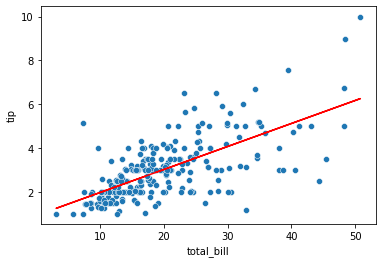

In [97]:
predicted_y = model.predict(tips[["total_bill"]])
sns.scatterplot(x='total_bill', y='tip', data=tips)
plt.plot(tips["total_bill"], predicted_y, color = 'r')
plt.xlabel('total_bill')
plt.ylabel('tip');

## Question 4 – Multiple Linear Regression

In the previous parts we showed how to establish relationships between one independent explanatory variable and one response variable. However, with real-world problems you will often want to use **multiple features** to model and predict a response variable. To do so, we will use multiple linear regression, as discussed in Lecture 13. Multiple linear regression attempts to model the relationship between two or more explanatory variables and a response variable by fitting a linear equation to the observed data. Formally, the model for multiple linear regression, given $p$ features is:

$$y_i = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + … + \theta_p x_p $$

Please note that we have been using the terms **features**, **independent variables**, and **explanatory variables** interchangeably. Usually “features” are used in the context of machine learning when you are trying to make predictions. “Independent variables” and “explanatory variables” are mainly found in statistics, econometrics and other related fields which focus on understanding the relationship between a set of variables.  


For example, consider the plot below which shows fuel efficiency vs. engine power for several models of automobile.

In [98]:
# Here, we load the fuel dataset, and drop any rows that have missing data
vehicle_data = sns.load_dataset('mpg').dropna()
vehicle_data = vehicle_data.sort_values('horsepower', ascending=True)
vehicle_data.head(5)

mpg  cylinders  displacement  horsepower  weight  acceleration  \
19   26.0          4          97.0        46.0    1835          20.5   
102  26.0          4          97.0        46.0    1950          21.0   
326  43.4          4          90.0        48.0    2335          23.7   
325  44.3          4          90.0        48.0    2085          21.7   
244  43.1          4          90.0        48.0    1985          21.5   

     model_year  origin                             name  
19           70  europe     volkswagen 1131 deluxe sedan  
102          73  europe          volkswagen super beetle  
326          80  europe               vw dasher (diesel)  
325          80  europe             vw rabbit c (diesel)  
244          78  europe  volkswagen rabbit custom diesel

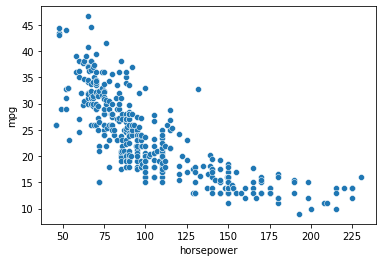

In [99]:
sns.scatterplot(x='horsepower', y='mpg', data=vehicle_data);

If we use `horsepower` alone to predict `mpg`, we get not-so-great results.

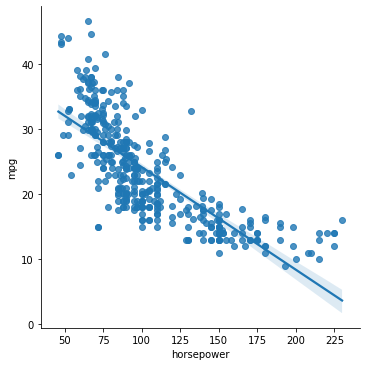

In [100]:
sns.lmplot(x='horsepower', y='mpg', data=vehicle_data);

Below, we make a residual plot of the residuals versus the fitted values for this simple linear regression model.

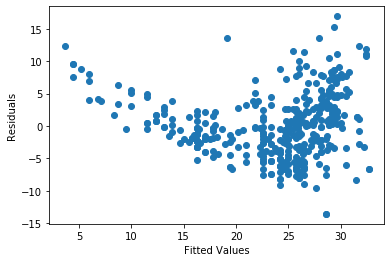

In [101]:
model_simple = LinearRegression()
model_simple.fit(vehicle_data[['horsepower']], vehicle_data['mpg'])
model_simple_fitted = model_simple.predict(vehicle_data[['horsepower']])
plt.scatter(model_simple_fitted, vehicle_data['mpg'] - model_simple_fitted)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals');

This is not an example of a "good" residual plot. There is an underlying parabolic pattern in the residuals, so we should consider adding a quadratic feature.

We can consider including functions of existing features as new features to help improve the predictive power of our model. (This is something we will discuss in further detail in the Feature Engineering lecture, Lecture 15.) For example, the line below adds a column which contains the square of the horsepower for each car in the dataset.

In [102]:
vehicle_data['hp^2'] = vehicle_data['horsepower'] ** 2
vehicle_data.head()

mpg  cylinders  displacement  horsepower  weight  acceleration  \
19   26.0          4          97.0        46.0    1835          20.5   
102  26.0          4          97.0        46.0    1950          21.0   
326  43.4          4          90.0        48.0    2335          23.7   
325  44.3          4          90.0        48.0    2085          21.7   
244  43.1          4          90.0        48.0    1985          21.5   

     model_year  origin                             name    hp^2  
19           70  europe     volkswagen 1131 deluxe sedan  2116.0  
102          73  europe          volkswagen super beetle  2116.0  
326          80  europe               vw dasher (diesel)  2304.0  
325          80  europe             vw rabbit c (diesel)  2304.0  
244          78  europe  volkswagen rabbit custom diesel  2304.0

### Question 4a

Using scikit learn's `LinearRegression`, create and fit a model that tries to predict `mpg` from `horsepower` AND `hp^2`. Name your model `model_multiple`.

- Hint: We do something very similar in Question 3.

<!--
BEGIN QUESTION
name: q4a
-->

In [107]:
model_multiple = LinearRegression()
model_multiple.fit(X = vehicle_data[['horsepower', 'hp^2']], y = vehicle_data['mpg'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [108]:
grader.check("q4a")

All tests passed!

After fitting, we can see the coefficients and intercept. Note, there are now two elements in `model_multiple.coef_`, since there are two features.

In [109]:
model_multiple.coef_

array([-0.46618963,  0.00123054])

In [110]:
model_multiple.intercept_

56.90009970211295

### Question 4b

Using the above values, in LaTeX, write out the function that the model is using to predict `mpg` from `horsepower` and `hp^2`.

<!--
BEGIN QUESTION
name: q4b
-->

y = theta0 + theta1 * x1 + theta2 * x2 + theta3 * x3 + .... + thetan * xn

The plot below shows the prediction of our model. It's much better!

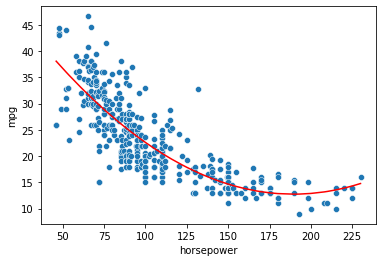

In [111]:
# DO NOT CHANGE THIS CELL
predicted_mpg = model_multiple.predict(vehicle_data[['horsepower', 'hp^2']])
sns.scatterplot(x='horsepower', y='mpg', data=vehicle_data)
plt.plot(vehicle_data['horsepower'],  predicted_mpg, color = 'r');

### Question 4c

In the cell below, explain why we use the term "linear" to describe the model above, even though it incorporates horsepower squared as a feature.

<!--
BEGIN QUESTION
name: q4c
-->

Since there is an increased trend in R^2, this indicates that there's a stronger correlation bewteen horsepower and mpg. Therefore, the term linear is still applicable in this case. 

To see exactly how much better our new model is, we can compare the Multiple $R^2$ from these two fits.  As described in Lecture 13,


$$R^2 = \frac{\text{variance of fitted values}}{\text{variance of true } y} = \frac{\sigma_\hat{y}^2}{\sigma_y^2}$$

Unlike $r$, the correlation coefficient we looked at in Question 1, $R^2$  can be used
in the multiple regression setting.  In simple regression, $r^{2}$ and Multiple $R^{2}$ are
the same.

In [112]:
predicted_mpg_horsepower_only = (
    LinearRegression()
    .fit(X = vehicle_data[['horsepower']], y = vehicle_data['mpg'])
    .predict(vehicle_data[['horsepower']])
)

r2_horsepower_only = np.var(predicted_mpg_horsepower_only) / np.var(vehicle_data['mpg'])
r2_both = np.var(predicted_mpg) / np.var(vehicle_data['mpg'])

print('Multiple R^2 using only horsepower: ', r2_horsepower_only)
print('Multiple R^2 using both horsepower and horsepower squared: ', r2_both)

Multiple R^2 using only horsepower:  0.6059482578894348
Multiple R^2 using both horsepower and horsepower squared:  0.6875590305127517


By introducing `hp^2` as a feature, our multiple $R^2$ value increased. Think about what this means with respect to the strength of our refined model.


### Question 4d

In the cell below, we assign the mean of the `mpg` column of the `vehicle_data` dataframe to `mean_mpg`. Given this information, what is the mean of `predicted_mpg` and `predicted_mpg_horsepower_only` arrays?

Hint: You should not have to call `np.mean` in your code.

<!--
BEGIN QUESTION
name: q4d
-->

In [113]:
mean_mpg = np.mean(vehicle_data['mpg'])
mean_predicted_mpg = np.mean(predicted_mpg_horsepower_only)
mean_predicted_mpg_horsepower_only = np.mean(r2_horsepower_only)

In [114]:
grader.check("q4d")

0 of 1 tests passed
    
    
    Tests failed:
    
           tests/q4d.py

Test result:
Trying:
    np.isclose(mean_predicted_mpg_horsepower_only, np.mean(predicted_mpg_horsepower_only), atol=0.001)
Expecting:
    True
**********************************************************************
Line 1, in tests/q4d.py 1
Failed example:
    np.isclose(mean_predicted_mpg_horsepower_only, np.mean(predicted_mpg_horsepower_only), atol=0.001)
Expected:
    True
Got:
    False

## Question 5

Let's take this one step further, and introduce a few more features.

### Question 5a

Again, using scikit learn's `LinearRegression`, create and fit a model that tries to predict `mpg` using each of the following as features:
- `horsepower`
- `hp^2`
- `model_year`
- `acceleration`

Call your model `model_many`.

<!--
BEGIN QUESTION
name: q5a
-->

In [ ]:
desired_columns = ...
model_many = LinearRegression()
model_many.fit(X = vehicle_data[desired_columns], y= vehicle_data['mpg'])

In [ ]:
grader.check("q5a")

The plot below shows the prediction of our more sophisticated model.

In [ ]:
predicted_mpg_many = model_many.predict(vehicle_data[['horsepower', 'hp^2', 'model_year', 'acceleration']])
sns.scatterplot(x='horsepower', y='mpg', data=vehicle_data)
plt.plot(vehicle_data['horsepower'],  predicted_mpg_many, color = 'r');

Think about what you see in the above plot. Why is the shape of our prediction curve so jagged? Do you think this is a good model to predict the `mpg` of some car we don't already have information on?

This idea – the **bias-variance tradeoff** – is an idea we will explore in the coming weeks.

### Question 5b

Lastly, set `r2_many` to be the multiple $R^2$ coefficient obtained by using `model_many`.

- Hint: This is very similar to what we did right before Question 4d. Use `predicted_mpg_many`.
- Note: The above plotting cell needs to have been run in order for this to work.

<!--
BEGIN QUESTION
name: q5b
-->

In [ ]:
r2_many = ...

In [ ]:
grader.check("q5b")

In [ ]:
print('Multiple R^2 using only horsepower: ', r2_horsepower_only)
print('Multiple R^2 using both horsepower and horsepower squared: ', r2_both)
print('Multiple R^2 using horsepower, horsepower squared, model year, and acceleration: ', r2_many)

If everything was done correctly, the multiple $R^2$ of our latest model should be substantially higher than that of the previous two models. This is because multiple $R^2$ increases with the number of covariates we add to our model. 

We might not always want to use models with large multiple $R^2$ values because these models could be overfitting to the training data, and won't generalize well to unseen data. Again, this is an idea we will explore in future lectures and assignments.

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [ ]:
grader.check_all()

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export("lab07.ipynb", pdf=False)